## Autoencoders

Examples and useful reading:
- https://github.com/napsternxg/pytorch-practice/blob/master/Pytorch%20-%20MMD%20VAE.ipynb
- https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
- https://github.com/Fraser-Greenlee/T5-VAE

Datasets:
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
- https://lionbridge.ai/datasets/20-best-image-datasets-for-computer-vision/

The following autoencoder was trained on the Visual Genome dataset of 40k+ images of various sizes.
Using PyTorch transformers we can bootstrap the dataset by flipping the images, adding random noise, etc.

This workbook is basically a scratch pad for iterating on a simple auto encoder for use in upcoming projects within this repo. In theory it'll be used as a pre-processor for things like image labeling and in reinforcement learning for games. The idea is that by compressing the image via the encoder network in a way that preserves important structure we can reduce the size and/or training time of downstream networks.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import math

from data.visual_genome import VisualGenomeDataset
from torch.utils.data import DataLoader

from encoders import cnn

# filter the annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def train(model, train_loader, checkpoint_path='./autoencoder-continued.cpt', num_epochs=5, learning_rate=1e-3, restore=False):
    criterion = nn.MSELoss().cuda() # mean square error loss
    device = torch.device('cuda:0')
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    loss = None
    if restore:
        model.load(checkpoint_path, optimizer)

    model = model.to(device)
    for epoch in range(num_epochs):
        print('Epoch: ', epoch)
        i = 0
        for img in train_loader:
            img = img.cuda()
            optimizer.zero_grad()
            recon = model(img)
            loss = criterion(recon, img)
            del recon, img
            loss.backward()
            i += 1
            if i % 25 == 0:
                try:
                    print('Epoch:{}, Batch:{}, loss:{:.4f}'.format(epoch, i, loss.item()))
                except UnboundLocalError:
                    pass
            del loss
            optimizer.step()
            torch.cuda.empty_cache()
    return model


In [4]:
model = cnn.AutoEncoder(3, mid_channels=3)
crops = [
#     (320, 400),
    (400,400),
    (240,240),
#     (240,320),
    (400,240)
]
# model.to(torch.device('cpu'))
for crop in crops:
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(500),
        transforms.RandomCrop(crop),
        transforms.ToTensor(),
    ])

    data = VisualGenomeDataset('./data/images/1', transform=transform)
    print('img: ', data[0].shape)
    print('rec:', model(data[0].unsqueeze(0)).shape)
    print('')

img:  torch.Size([3, 400, 400])
rec: torch.Size([1, 3, 400, 400])

img:  torch.Size([3, 240, 240])
rec: torch.Size([1, 3, 240, 240])

img:  torch.Size([3, 400, 240])
rec: torch.Size([1, 3, 400, 240])



In [ ]:
m = cnn.AutoEncoder(3, latent_channels=3)
m.load_state_dict(model.state_dict())
conv = torch.nn.Sequential(
    torch.nn.Conv2d(6, 6, kernel_size=6, stride=2, padding=1),
    torch.nn.BatchNorm2d(6),
    torch.nn.ReLU()
)


c0 = m.encoder[0]
c1 = conv
c2 = m.encoder[1]
c3 = m.encoder[2]
m.encoder = torch.nn.ModuleList([c0, c1, c2, c3])


deconv = torch.nn.Sequential(
    torch.nn.ConvTranspose2d(6, 6, kernel_size=6, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(6)
)

d0 = m.decoder[0]
d1 = deconv
d2 = m.decoder[1]
d3 = m.decoder[2]
m.decoder = torch.nn.ModuleList([d0, d1, d2,d3])

t = torch.rand(1,3,800,800)
print(m(t).shape)
for layer in m.encoder:
    t = layer(t)
print(t.shape)

In [11]:
model = cnn.AutoEncoder(3, mid_channels=10)

checkpoint = torch.load('./dist/cnn.pt')
model.load_state_dict(checkpoint['model_state'])
model.to(torch.device('cuda:0'))
crops = [
#     (320, 400),
#     (240,320),
#     (240,240),
#     (400,240),
    (400,400),
]
for crop in crops:
#     print('running with crop:', crop)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(500),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(crop),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
    ])

    data = VisualGenomeDataset('./data/images/1', transform=transform)
    dataloader = DataLoader(data, batch_size=200, shuffle=True, num_workers=3)
#     model = train(model, dataloader, num_epochs=2, learning_rate=3e-3)
#     model = train(model, dataloader, num_epochs=1, learning_rate=1e-3)
#     model = train(model, dataloader, num_epochs=1, learning_rate=3e-4)
#     model = train(model, dataloader, num_epochs=2, learning_rate=1e-3)
    model = train(model, dataloader, num_epochs=1, learning_rate=3e-5)

# model.save('./cnn-3.pt')

Epoch:  0
Epoch:0, Batch:25, loss:0.0050
Epoch:0, Batch:50, loss:0.0049
Epoch:0, Batch:75, loss:0.0051
Epoch:0, Batch:100, loss:0.0047
Epoch:0, Batch:125, loss:0.0049
Epoch:0, Batch:150, loss:0.0052
Epoch:0, Batch:175, loss:0.0052
Epoch:0, Batch:200, loss:0.0049


In [14]:
state = {'model_state': model.state_dict(), 'loss': .0049}
torch.save(state, './dist/cnn.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 95, 95])
orig shape torch.Size([3, 400, 400])
recon shape torch.Size([3, 400, 400])


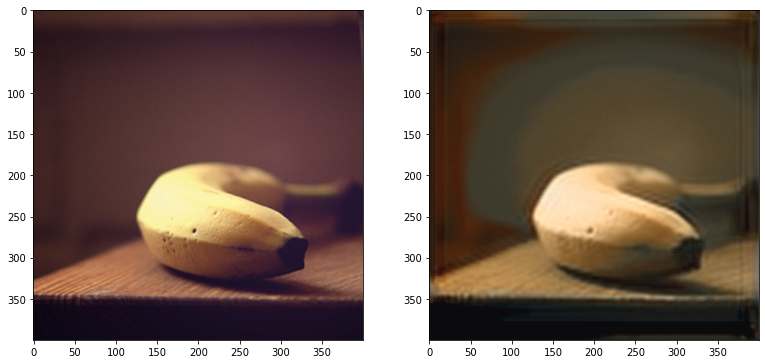

In [22]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(500),
        transforms.RandomCrop(crop),
        transforms.ToTensor(),
    ])

data = VisualGenomeDataset('./data/images/1', transform=transform)
i = data[170]
model.eval()
model.to(torch.device('cpu'))

z = i.unsqueeze(0)
for layer in model.encoder:
    z = layer(z)

print(z.shape)

recon = model(i.permute(0,1,2).unsqueeze(0).float())
recon = recon.detach()[0]
print('orig shape', i.shape)
print('recon shape', recon.shape)

f, axarr = plt.subplots(1,2, figsize=(13,13))
axarr[0].imshow(i.permute(1,2,0))
axarr[1].imshow(recon.permute(1,2,0))